In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time

import Bell_EBM as ebm

In [10]:
planetPrime = ebm.Planet('gas', rad=1.800*const.R_jup.value, mass=1.470*const.M_jup.value,
                    Porb=1.09142030, a=0.04340*const.au.value, inc=83.37, vWind=5e3, e=0.3)
starPrime = star = ebm.Star(teff=6300., rad=1.59)

In [43]:
def Optimize(_planet, _star, _error, verbose=False):
    planet = _planet
    star = _star
    aError = _error

    #==========High Res Baseline Creation==========
    tInt = time.time()
    if (verbose == True): 
        print("Starting baseline generation...")

    baseUpdates = 3000. #Amount of timesteps in baseline
    baseOrbits = 2 #Amount of orbits in baseline

    planet.map = ebm.Map.Map(nlat=48)
    system = ebm.System(star, planet)

    Teq = system.get_teq()
    T0 = np.ones_like(system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+system.planet.Porb*baseOrbits
    dt = system.planet.Porb/baseUpdates
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

    if (planet.orbit.e != 0.):
        T0 = baselineMaps[-1]
        t0 = baselineTimes[-1]
        t1 = t0+system.planet.Porb
        dt = (system.planet.Porb)/1000.
        baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
        baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)
    else:
        baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)

    tFin = time.time()
    if (verbose == True): 
        print("Baseline generation complete; Time to Compute: " + str(round(tFin-tInt,2)) + "s")

    #===========Initial data creationg================
    space_points = 10
    temp_points = 10
    data = np.zeros(shape=((space_points*temp_points),5))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            data[(i*space_points)+j,0]= ((i+1)*50)+0
            data[(i*space_points)+j,1] = 3+((j+1)*1)
    if (verbose == True): 
        print("Data points assigned")

    #==================Testing Area======================
    phaseBaseline = system.get_phase(baselineTimes).flatten()
    order = np.argsort(phaseBaseline)
    baselineLightcurve = baselineLightcurve[order]
    phaseBaseline = phaseBaseline[order]

    if (verbose == True): 
        print("Starting tests...")
    tInt = time.time()
    for i in range(0, (space_points*temp_points)):

        planet.map = ebm.Map.Map(nlat=data[i,1])
        system = ebm.System(star, planet)

        TotalTimeToCompute = 0.

        Teq = system.get_teq()
        T0 = np.ones_like(system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+system.planet.Porb*1
        dt = system.planet.Porb/data[i,0]
        times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
        TotalTimeToCompute += ttc

        if (planet.orbit.e != 0):
            T0 = maps[-1]
            t0 = times[-1]
            t1 = t0+system.planet.Porb
            dt = system.planet.Porb/data[i,0]
            times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
            TotalTimeToCompute += ttc

        testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

        phaseTest = system.get_phase(times).flatten()
        order = np.argsort(phaseTest)
        testLightcurve = testLightcurve[order]
        phaseTest = phaseTest[order]
        testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)

        data[i,2] = (1e6)*(np.amax(np.absolute(baselineLightcurve - testLightcurve)))
        data[i,4] = TotalTimeToCompute*(1e3)
    tFin = time.time()
    if (verbose == True): 
        print("Tests finished; Time to compute: " + str(round(tFin-tInt,2)) + "s")

    #=================Finding best thing===================
    print(data) #For debugging purposes 
    iBest = None
    for i in range(0,space_points*temp_points):
        if (data[i,2]<=aError):
            if (iBest == None):
                iBest = i
            if(data[i,4] < data[iBest,4]):
                iBest = i

    if (iBest == None):
        print("No points match requested error")
    else:
        print("Temporal: " + str(data[iBest,0]) + " Spacial: " + str(data[iBest,1]))
        print("Time for compute: " + str(round(data[iBest, 4],2)) +"s : Error: " + str(round(data[iBest, 2],2)) + "ppm")
        print("Expected compute time @ 1,000,000 cycles: " + str((round((data[iBest, 4]*1e3/60)/60,2))) + " Hrs")
        
    #=========Create Maps==================
    if (verbose == True):
        planet.map = ebm.Map.Map(nlat=data[iBest,1])
        system = ebm.System(star, planet)

        TotalTimeToCompute = 0.

        Teq = system.get_teq()
        T0 = np.ones_like(system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+system.planet.Porb*1
        dt = system.planet.Porb/data[iBest,0]
        times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
        TotalTimeToCompute += ttc

        if (planet.orbit.e != 0):
            T0 = maps[-1]
            t0 = times[-1]
            t1 = t0+system.planet.Porb
            dt = system.planet.Porb/data[iBest,0]
            times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
            TotalTimeToCompute += ttc

        testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

        phaseTest = system.get_phase(times).flatten()
        order = np.argsort(phaseTest)
        testLightcurve = testLightcurve[order]
        phaseTest = phaseTest[order]
        testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        
        plt.plot((baselineLightcurve)*1e6, lw=2, c='g')
        plt.plot((testLightcurve)*1e6, lw=1, c='r')

Starting baseline generation...
Baseline generation complete; Time to Compute: 18.36s
Data points assigned
Starting tests...
Tests finished; Time to compute: 15.01s
[[ 50.           4.         294.95196409   0.          21.75617218]
 [ 50.           5.         237.95808505   0.          21.41499519]
 [ 50.           6.         216.39217013   0.          21.5909481 ]
 [ 50.           7.         192.01134822   0.          22.09663391]
 [ 50.           8.         178.56827892   0.          23.15616608]
 [ 50.           9.         168.72845098   0.          23.6749649 ]
 [ 50.          10.         157.55090621   0.          24.20854568]
 [ 50.          11.         148.61848674   0.          22.81665802]
 [ 50.          12.         143.23578135   0.          29.9448967 ]
 [ 50.          13.         135.69542497   0.          31.12006187]
 [100.           4.         258.26796075   0.          42.96827316]
 [100.           5.         202.00008967   0.          39.41941261]
 [100.           6.

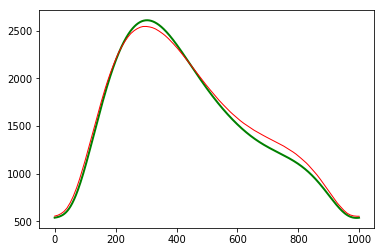

In [45]:
Optimize(planetPrime, starPrime, 100., True)

In [30]:
ebm.System(starPrime, planetPrime).get_teq()

2197.7511940164973